# patient RNA-seq analysis (R)

In [1]:
# R script to analyze patient RNA-seq samples
# input:  kallisto gene count table
# output: DESeq2 results

rm(list = ls())

# load kallisto gene count table
# generated by /home/xw2629/xuebing/RPL3L/code/rpl3l-mutant-paper/patient-rna-seq-mane1.4.sh
countFile <- "/media/rna/sequencing_data/RPL3L/rnaseq-patient-sample/kallisto-20250727-MANEv1.4_Plasmid/gene.count.tsv"
# load the count data
cts <- read.table(countFile,sep="\t",header=T)
# set row names to gene names
rownames(cts) <- cts[,1]
# remove the first column which is gene names
cts <- cts[,-1]
# convert to matrix
cts <- as.matrix(cts)
# convert to integers
cts <- round(cts)

# total number of genes
print(paste("Total number of genes:", nrow(cts)))

# print the first few rows to check
print(head(cts))

[1] "Total number of genes: 19344"
       MM031 MM032 X226dpb X6mpb X127dpb
A2M    10170 11641   11865  9504   16690
NAT2       1     2       1     1       0
ACADM   5990  6198    1423   649    3419
ACADS    871  1164    1605  1896    1761
ACADVL 13809 16332   19813 27859   22804
ACAT1   5788  6814    6977  2206   10679


In [2]:
# sample names and groups
sample <- colnames(cts)
condition=factor(c('Patient','Patient','Control','Control','Control'))
coldata <- data.frame(sample=sample,condition=condition)
print(coldata)

   sample condition
1   MM031   Patient
2   MM032   Patient
3 X226dpb   Control
4   X6mpb   Control
5 X127dpb   Control


In [11]:
# DESeq2 for differential expression analysis

# load DESeq2 library 
library("DESeq2")

# create DESeqDataSet object
# from the count matrix and colData
dds <- DESeqDataSetFromMatrix(countData = cts,
                              colData = coldata,
                              design = ~ condition)

# Expressed genes filter
# filter out genes with low counts
# we will keep genes with counts greater than 10 in at least 3 samples
# this is to avoid lowly expressed genes which can introduce noise in the analysis 
smallestGroupSize <- 3
keep <- rowSums(counts(dds) > 10) >= smallestGroupSize
dds <- dds[keep,]
dds <- DESeq(dds)

print(paste("Number of genes after filtering:", nrow(dds)))

# comparison: patient vs control
# FDR < 0.05
res <- results(dds, contrast=c("condition","Patient","Control"),alpha=0.05)

summary(res)

# sort results by p-value
resOrdered <- res[order(res$pvalue),]

# save results to a file
write.table(as.data.frame(resOrdered),file="./deseq2-D308_vs_infant.tsv",sep='\t',quote=FALSE,col.names=NA)


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Number of genes after filtering: 13639"

out of 13639 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1060, 7.8%
LFC < 0 (down)     : 1577, 12%
outliers [1]       : 18, 0.13%
low counts [2]     : 0, 0%
(mean count < 8)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] "Number of RPL genes: 52"
 [1] "RPL9"    "RPL3"    "RPL4"    "RPL5"    "RPL6"    "RPL7"    "RPL7A"  
 [8] "RPL11"   "RPL12"   "RPL13"   "RPL23"   "RPL18"   "RPL18A"  "RPL19"  
[15] "RPL21"   "RPL22"   "RPL23A"  "RPL24"   "RPL26"   "RPL27"   "RPL30"  
[22] "RPL27A"  "RPL28"   "RPL29"   "RPL31"   "RPL32"   "RPL35A"  "RPL37"  
[29] "RPL37A"  "RPL38"   "RPL39"   "RPL36AL" "RPLP0"   "RPLP1"   "RPLP2"  
[36] "RPL14"   "RPL17"   "RPL41"   "RPL22L1" "RPL8"    "RPL34"   "RPL7L1" 
[43] "RPL15"   "RPL3L"   "RPL10"   "RPL10A"  "RPL35"   "RPL13A"  "RPL26L1"
[50] "RPL36A"  "RPL36"   "RPL39L" 
[1] "Number of RPS genes: 45"
 [1] "RPS3"     "RPS3A"    "RPS4X"    "RPS4Y1"   "RPS5"     "RPS6"    
 [7] "RPS7"     "RPS8"     "RPS9"     "RPS10"    "RPS11"    "RPS12"   
[13] "RPS13"    "RPS15"    "RPS15A"   "RPS16"    "RPS17"    "RPS19"   
[19] "RPS20"    "RPS21"    "RPS23"    "RPS25"    "RPS26"    "RPS27"   
[25] "RPS28"    "RPS29"    "RPSA2"    "RPSA"     "RPS2"     "RPS6KA1" 
[31] "RPS27A"   "RPS6KB1"

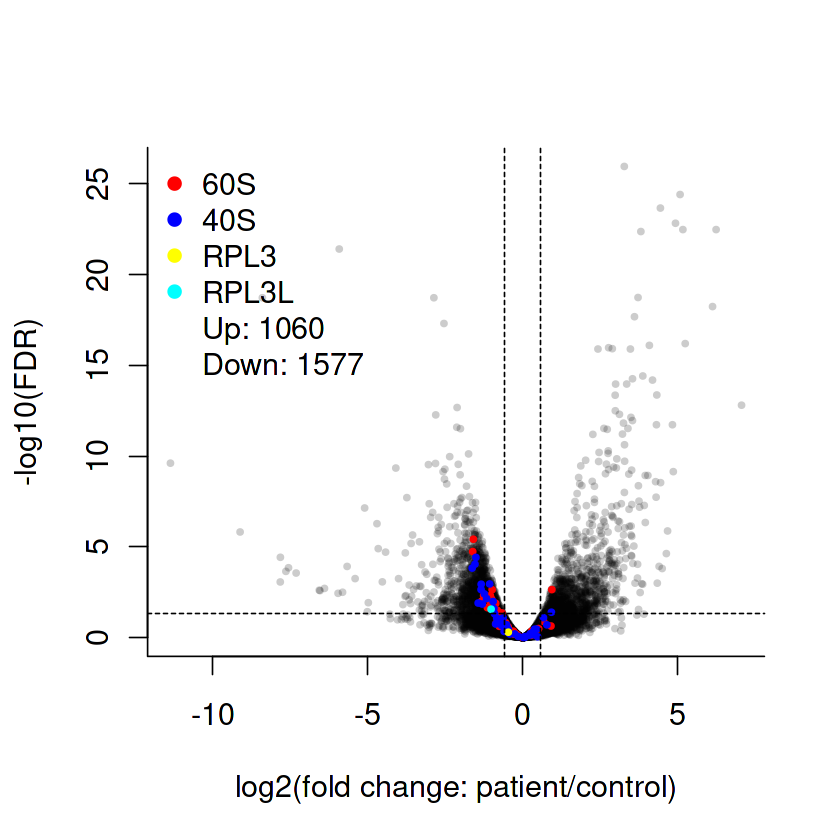

In [35]:
# plotting DESeq2 results

# genes to highlight
genes <- rownames(res)
idx_RPL <- grep('^RPL',genes) # 60S ribosomal proteins
idx_RPS <- grep('^RPS',genes) # 40S ribosomal proteins

idx_RPL3 <- genes=="RPL3"
idx_RPL3L <- genes=="RPL3L"

print(paste("Number of RPL genes:", length(idx_RPL)))
print(genes[idx_RPL])
print(paste("Number of RPS genes:", length(idx_RPS)))
print(genes[idx_RPS])

#  number of significant genes
up = sum(res$padj < 0.05 & res$log2FoldChange > log2(1.5),na.rm = TRUE)
dn = sum(res$padj < 0.05 & res$log2FoldChange < -log2(1.5),na.rm = TRUE)

# plot
par(cex=1.5)
plot(res$log2FoldChange,-log10(res$padj),pch=16,cex=0.5,col=rgb(0,0,0,0.2),
    bty='l',xlab='log2(fold change: patient/control)', ylab='-log10(FDR)')
points(res$log2FoldChange[idx_RPL],-log10(res$padj[idx_RPL]),col='red',pch=16,cex=0.5)
points(res$log2FoldChange[idx_RPS],-log10(res$padj[idx_RPS]),col='blue',pch=16,cex=0.5)
points(res$log2FoldChange[idx_RPL3],-log10(res$padj[idx_RPL3]),col='yellow',pch=16,cex=0.5)
points(res$log2FoldChange[idx_RPL3L],-log10(res$padj[idx_RPL3L]),col='cyan',pch=16,cex=0.5)
abline(h= -log10(0.05),lty=2)
abline(v=log2(1.5),lty=2)
abline(v=-log2(1.5),lty=2)
legend('topleft',legend=c('60S','40S','RPL3','RPL3L',
                          paste('Up:',up),paste('Down:',dn)),
       col=c('red','blue','yellow','cyan'),pch=c(16,16,16,16,NA,NA),bty='n',pt.cex=1)






In [38]:
# RPL3L FDR and fold change  
print( res$padj[idx_RPL3L] )
print( res$log2FoldChange[idx_RPL3L] )
print( 2^res$log2FoldChange[idx_RPL3L] )
# # RPL3L fold change and FDR
print( res$padj[idx_RPL3] )
print( res$log2FoldChange[idx_RPL3] )
print( 2^res$log2FoldChange[idx_RPL3] )


[1] 0.02729818
[1] -1.024395
[1] 0.4916164


[1] 0.5068026
[1] -0.4684816
[1] 0.7227248


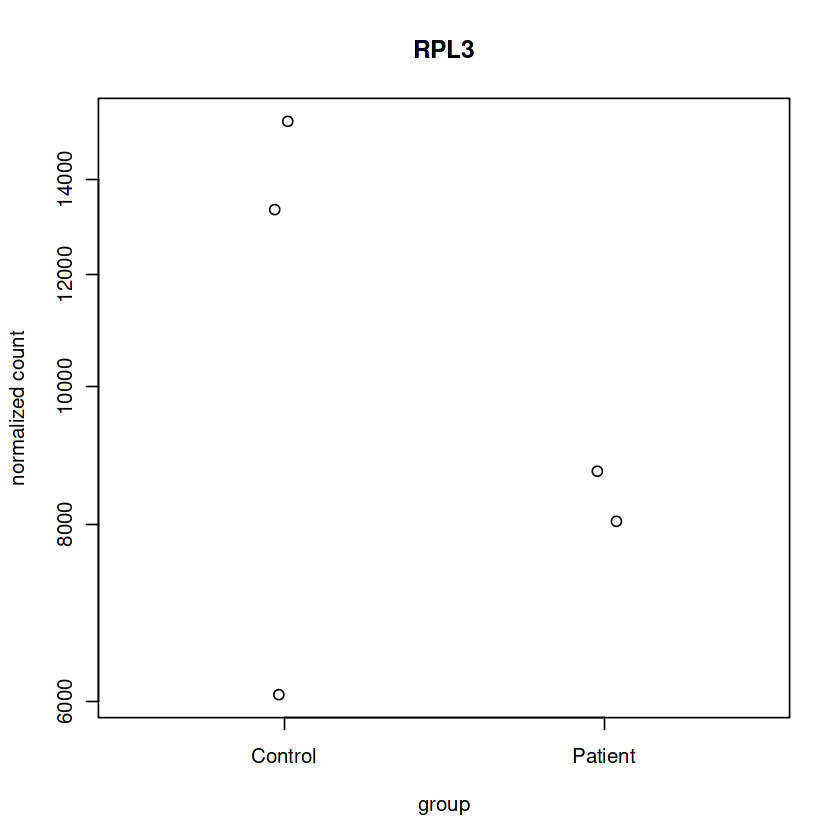

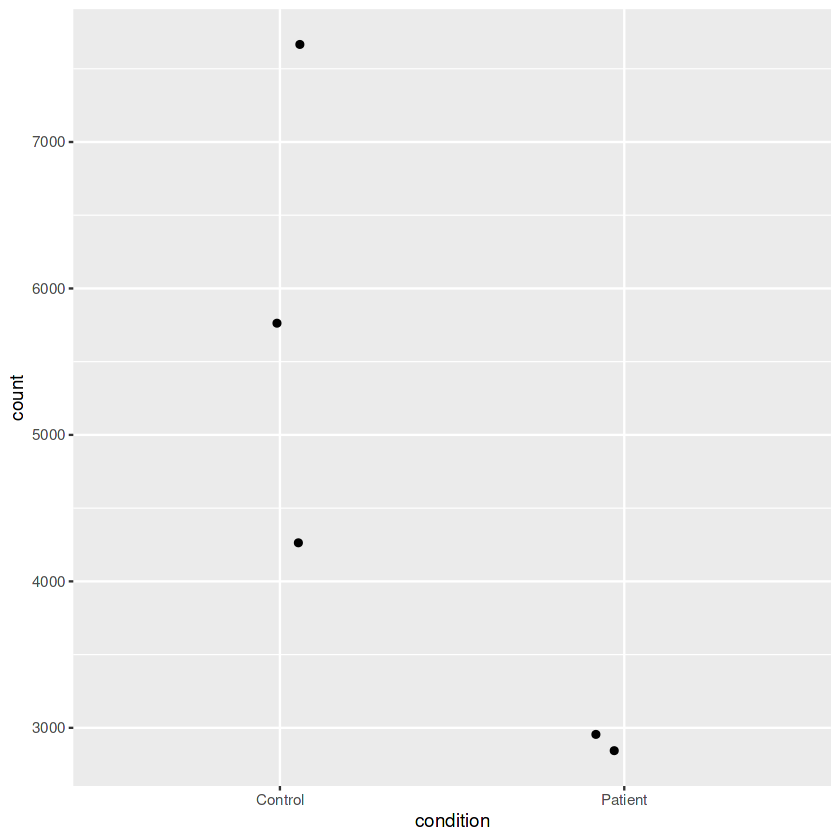

In [39]:
#plotCounts(dds, gene=which.min(res$padj), intgroup="condition")
plotCounts(dds, gene="RPL3", intgroup="condition")
d = plotCounts(dds, gene="RPL3L", intgroup="condition",returnData=TRUE)
#plotCounts(dds, gene="RPL6", intgroup="condition")
library("ggplot2")
ggplot(d, aes(x=condition, y=count)) + 
  geom_point(position=position_jitter(w=0.1,h=0)) 

In [40]:
pdf(file = "RPL3L.pdf")
par(cex=1.5)
mp = barplot(height=c(mean(d[d$condition=="Patient",]$count), mean(d[d$condition=="Control",]$count) ), names=c("D308","Neonate"), border="white", col="gray" ,ylim=c(0,7500))
print(mp)
points(c(0.7,0.7),d[d$condition=="Patient",]$count,cex=3)
points(c(1.9,1.9,1.9),d[d$condition=="Control",]$count,cex=3)
dev.off()

     [,1]
[1,]  0.7
[2,]  1.9


pdf 
  2

In [ ]:
geneScore -i /media/rna/sequencing_data/RPL3L/rnaseq-patient-sample/deseq2-D308_vs_infant.tsv -skip 1 -cScore 3 -d /home/xw2629/genomes/geneSets/msigdb_v2024.1.Hs_GMTs/msigdb.v2024.1.Hs.symbols.gmt -o msigdb-deseq2-D308-vs-infant -plot -p 1e-2

geneScore -i /media/rna/sequencing_data/RPL3L/rnaseq-patient-sample/deseq2-A51LV_vs_infant.tsv -skip 1 -cScore 3 -d /home/xw2629/genomes/geneSets/msigdb_v2024.1.Hs_GMTs/msigdb.v2024.1.Hs.symbols.gmt -o msigdb-deseq2-A51LV-vs-infant -plot -p 1e-2


In [ ]:
geneScore -i /media/rna/sequencing_data/RPL3L/rnaseq-patient-sample/deseq2-D308_vs_infant.tsv -skip 1 -cScore 3 -d /home/xw2629/genomes/geneSets/msigdb_v2024.1.Hs_GMTs/msigdb.v2024.1.Hs.symbols.gmt -o msigdb-deseq2-D308-vs-infant -plot -p 1e-2 -geneset HAMAI_APOPTOSIS_VIA_TRAIL_UP

geneScore -i /media/rna/sequencing_data/RPL3L/rnaseq-patient-sample/deseq2-D308_vs_infant.tsv -skip 1 -cScore 3 -d /home/xw2629/genomes/geneSets/msigdb_v2024.1.Hs_GMTs/msigdb.v2024.1.Hs.symbols.gmt -o msigdb-deseq2-D308-vs-infant -plot -p 1e-2 -geneset THUM_SYSTOLIC_HEART_FAILURE_UP

geneScore -i /media/rna/sequencing_data/RPL3L/rnaseq-patient-sample/deseq2-D308_vs_infant.tsv -skip 1 -cScore 3 -d /home/xw2629/genomes/geneSets/msigdb_v2024.1.Hs_GMTs/msigdb.v2024.1.Hs.symbols.gmt -o msigdb-deseq2-D308-vs-infant -plot -p 1e-2 -geneset RIBOSOM

geneScore -i /media/rna/sequencing_data/RPL3L/rnaseq-patient-sample/deseq2-D308_vs_infant.tsv -skip 1 -cScore 3 -d /home/xw2629/genomes/geneSets/msigdb_v2024.1.Hs_GMTs/msigdb.v2024.1.Hs.symbols.gmt -o msigdb-deseq2-D308-vs-infant -plot -p 1e-2 -geneset DESCARTES

geneScore -i /media/rna/sequencing_data/RPL3L/rnaseq-patient-sample/deseq2-A51LV_vs_infant.tsv -skip 1 -cScore 3 -d /home/xw2629/genomes/geneSets/msigdb_v2024.1.Hs_GMTs/msigdb.v2024.1.Hs.symbols.gmt -o msigdb-deseq2-A51LV-vs-infant -plot -p 1e-2 -geneset THUM_SYSTOLIC_HEART_FAILURE_UP
geneScore -i /media/rna/sequencing_data/RPL3L/rnaseq-patient-sample/deseq2-A51LV_vs_infant.tsv -skip 1 -cScore 3 -d /home/xw2629/genomes/geneSets/msigdb_v2024.1.Hs_GMTs/msigdb.v2024.1.Hs.symbols.gmt -o msigdb-deseq2-A51LV-vs-infant -plot -p 1e-2 -geneset HAMAI_APOPTOSIS_VIA_TRAIL_UP  

In [ ]:
awk '{
    if (match($0, /\\([^\\)]*\\)/)) {
        start = RSTART + 1;  # Start position of the substring (after opening bracket)
        len = RLENGTH - 2;   # Length of the substring (excluding brackets)
        print substr($0, start, len);
    }
}' filename

ERROR: Error: object 'dds' not found


In [41]:
# plot gene set analysis
x=read.table("/home/xw2629/xuebing/RPL3L/code/msigdb-deseq2-D308-vs-infant-ks-20250727/geneset_summary.txt",header=T)
print(head(x))

                                                                        gene.set
1                                                   HAMAI_APOPTOSIS_VIA_TRAIL_UP
2                               LIU_OVARIAN_CANCER_TUMORS_AND_XENOGRAFTS_XDGS_DN
3                                           DESCARTES_FETAL_CEREBELLUM_MICROGLIA
4                                                 MILI_PSEUDOPODIA_HAPTOTAXIS_UP
5                                                                        MIR3662
6 ERWIN_COHEN_BLOOD_LIVE_VACCINE_TC_83_AGE_23_48YO_VACCINATED_VS_CONTROL_14DY_UP
                                                                                                                           description
1                                                   https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/HAMAI_APOPTOSIS_VIA_TRAIL_UP
2                               https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/LIU_OVARIAN_CANCER_TUMORS_AND_XENOGRAFTS_XDGS_DN
3                           

In [42]:
filter = x$count.f >=50 & x$count.b >=50
print(sum(filter))
x = x[filter,]


[1] 15170


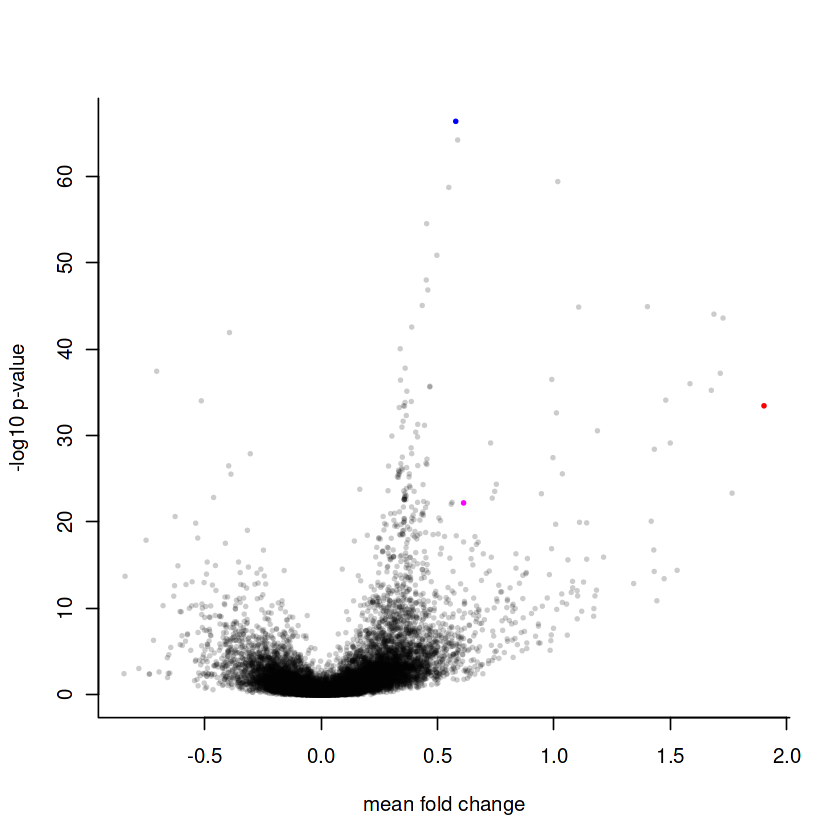

In [43]:
plot(x$mean_f_minus_b,-log10(x$ks.p.value),pch=16,cex=0.5,col=rgb(0,0,0,0.2),bty='l',xlab='mean fold change', ylab='-log10 p-value')
heart_myeloid = grep("DESCARTES_FETAL_HEART_MYELOID_CELLS",x$gene.set)
apoptosis = grep("HAMAI_APOPTOSIS_VIA_TRAIL_UP",x$gene.set)
heart_failure = grep("THUM_SYSTOLIC_HEART_FAILURE_UP",x$gene.set)
points(x$mean_f_minus_b[heart_myeloid],-log10(x$ks.p.value[heart_myeloid]),col='red',pch=16,cex=0.5)
points(x$mean_f_minus_b[apoptosis],-log10(x$ks.p.value[apoptosis]),col='blue',pch=16,cex=0.5)
points(x$mean_f_minus_b[heart_failure],-log10(x$ks.p.value[heart_failure]),col='magenta',pch=16,cex=0.5)

